In [1]:
from preprocess import surgery_preprocess
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
import numpy as np


X_train, X_test, y_train, y_test = surgery_preprocess()
kf = StratifiedKFold(n_splits = 5, shuffle=True)
smoter_nc = SMOTENC(categorical_features = list(range(2,14))+list(range(26,30)),
                             k_neighbors=2)
ros = RandomOverSampler()

In [2]:
lr = LogisticRegression(max_iter=1000)
lr_pipe = Pipeline([('upsample', ros), ('model', lr)])
lr_pipe.fit(X_train, y_train)


Pipeline(steps=[('upsample', RandomOverSampler()),
                ('model', LogisticRegression(max_iter=1000))])

In [3]:
import shap
lr_explainer = shap.KernelExplainer(lr_pipe.predict_proba, X_test)
# Predict_proba returns probs for each class. This shapvals object
# will similarly have shap values corresponding to each class
lr_shapvals = lr_explainer.shap_values(X_test)
shap.initjs() # Needed to show plots

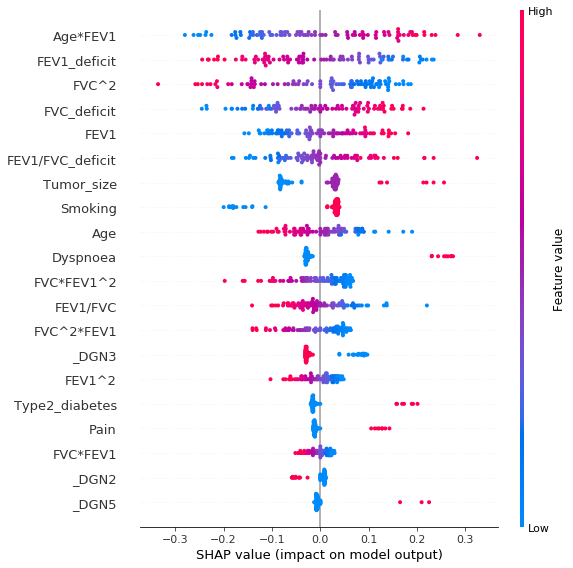

In [4]:
# Global summary
shap.summary_plot(lr_shapvals[1], X_test, plot_type="dot")

Dependence plot: Shows how the SHAP value for a feature varies with that feature's value. Automatically colors by the feature most correlated with the one chosen

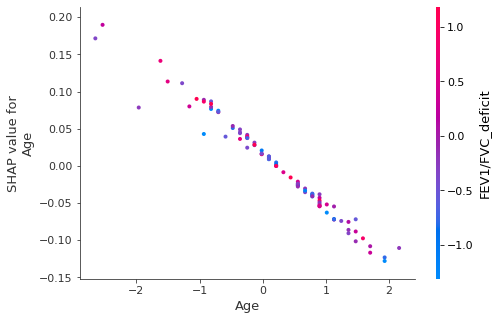

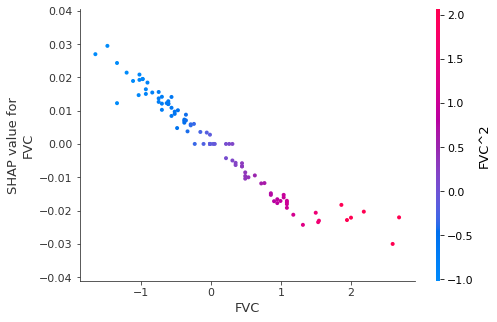

In [5]:
shap.dependence_plot('Age', lr_shapvals[1], X_test)
shap.dependence_plot('FVC', lr_shapvals[1], X_test)

High FVC = very negative SHAP value = more likely to predict a 0

We can also do a summary plot for all classes at once. The size of the colored part of a bar shows how important that feature is to predicting that class. With only two classes, it will be a mirror image in our case.

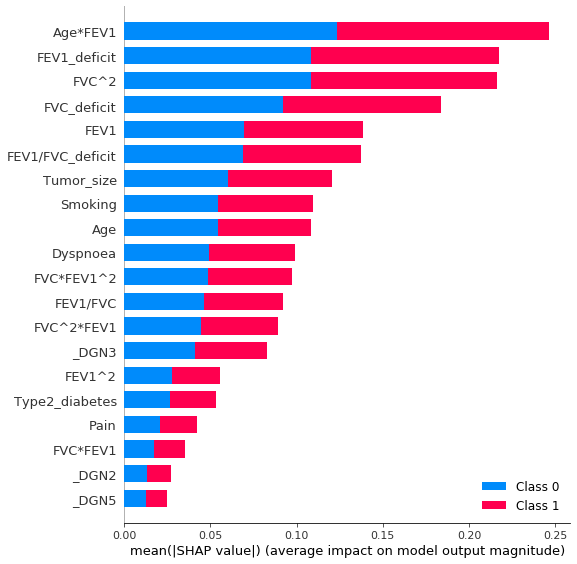

In [6]:
shap.summary_plot(lr_shapvals, X_test)

Force plot for a single instance, which shows how the features influenced that prediction.

Size of the wedge represents its importance.

Red = moves the prediction higher (more likely to the specified class, 1 in this case), blue = makes it go lower

(I THINK that if the value displayed in bold is greater than the base value for the class - given by  lr_explainer.expeceted_value - then that class is predicted)

In [7]:
shap_values_0 = lr_explainer.shap_values(X_test.iloc[0,:], nsamples=1000)
# First argument: Base value that feature contributions start from
# Second: Shap values for each feature for our predictions
# Third: Feature values
# Note that the model predicted 0 for X_test[0]
shap.force_plot(lr_explainer.expected_value[1], shap_values_0[1], X_test.iloc[0,:])

In [8]:
# An example where the model predicted a positive
shap_values_2 = lr_explainer.shap_values(X_test.iloc[2,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_2[1], X_test.iloc[2,:])

Global force plot. I do not know how to interpret this. Seems like each x is a sample, y is what the model predicted (ie the bold number in the single-instance force plot), and each segment of the blue/red is the SHAP value of a given feature for that instance. The model prediction (again, the bold number in the single-value fore plot) must be on the boundary of blue and red

In [9]:
shap.force_plot(lr_explainer.expected_value[1], lr_shapvals[1], feature_names=X_test.columns)
# We can also do this for just a few X's:
# shap.force_plot(lr_explainer.expected_value[1], np.array(lr_shapvals)[1,0:5],X_test.iloc[0:5])

In [19]:
sv = svm.SVC(C = 66, probability=True, kernel='linear')
sv_pipe = Pipeline([('upsample', ros), ('model', sv)])
sv_pipe.fit(X_train, y_train)

Pipeline(steps=[('upsample', RandomOverSampler()),
                ('model', SVC(C=66, kernel='linear', probability=True))])

In [27]:
import shap
sv_explainer = shap.KernelExplainer(sv_pipe.predict_proba, X_test)
sv_shapvals = sv_explainer.shap_values(X_test)
shap.initjs() # Needed to show plots

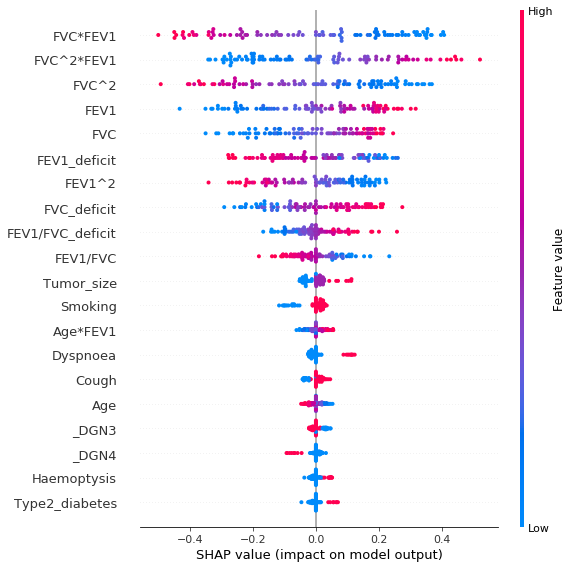

In [28]:
shap.summary_plot(sv_shapvals[1], X_test, plot_type="dot")

In [31]:
roc_auc_score(y_test, sv_pipe.predict_proba(X_test)[:,1])

0.5777576853526221

In [45]:
import lightgbm as lgb
cat_feats = list(range(2,11))+list(range(23,27))

lg_args = {'metric': 'binary_logloss', 'categorical_features': cat_feats,
          'model__bagging_fraction ': 0.8961293117889583,
  'model__lambda_l2': 9.264274430151037,
  'model__learning_rate': 0.1612108375152242,
  'model__max_depth': 5,
  'model__n_estimators': 36,
  'model__num_leaves': 14}
lg = lgb.LGBMClassifier(**lg_args)
lg_pipe = Pipeline([('upsample', ros), ('model', lg)])
lg_pipe.fit(X_train, y_train)

Pipeline(steps=[('upsample', RandomOverSampler()),
                ('model',
                 LGBMClassifier(categorical_features=[2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 23, 24, 25, 26],
                                metric='binary_logloss',
                                model__bagging_fraction =0.8961293117889583,
                                model__lambda_l2=9.264274430151037,
                                model__learning_rate=0.1612108375152242,
                                model__max_depth=5, model__n_estimators=36,
                                model__num_leaves=14))])

In [46]:
import shap
lg_explainer = shap.TreeExplainer(lg_pipe.steps[1][1])
lg_shapvals = lg_explainer.shap_values(X_test)
shap.initjs() # Needed to show plots

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


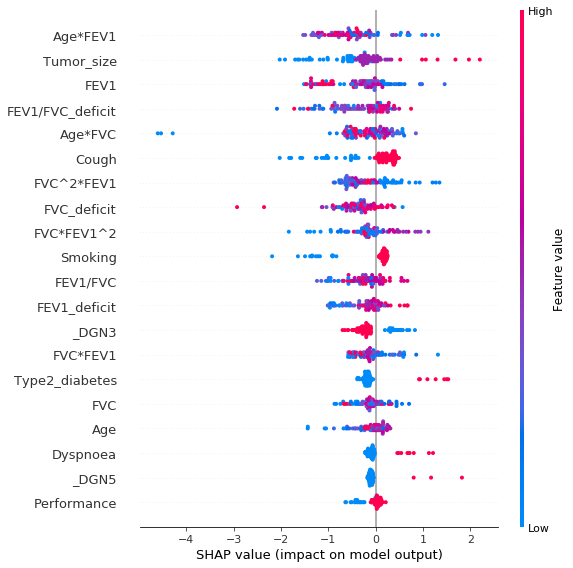

In [47]:
shap.summary_plot(lg_shapvals[1],X_test)

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_pipe = Pipeline([('upsample',ros),('model',rf)])
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('upsample', RandomOverSampler()),
                ('model', RandomForestRegressor())])

In [49]:
import shap
rf_explainer = shap.TreeExplainer(rf_pipe.steps[1][1])
rf_shapvals = rf_explainer.shap_values(X_test)
shap.initjs() # Needed to show plots

In [52]:
rf_shapvals.shape

(93, 27)

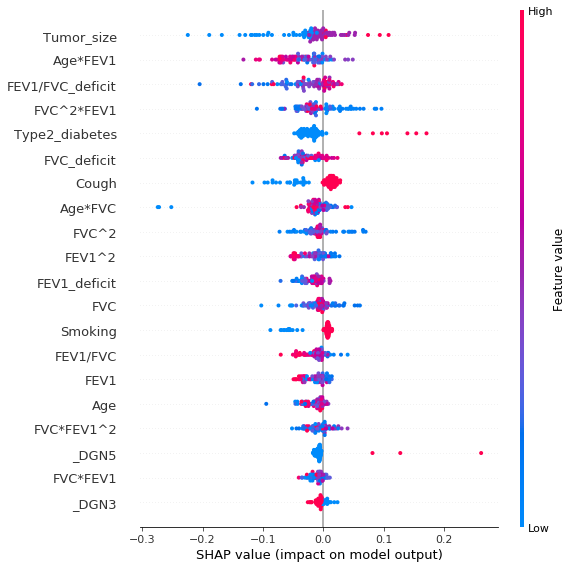

In [53]:
shap.summary_plot(rf_shapvals,X_test)